# **Image Classification of Dog Breed**

In [56]:
# Importing packages that are required
import warnings
import os
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from keras.applications.xception import Xception , preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from keras.layers.merge import concatenate

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix

1. **Need of Test and Train Data:** The test set of data is only used to make predictions and the train set is used to fit the model. A model is tested by making predictions against the test set after being processed using the training set. The train and test split is a quick and simple method to gauge how well prediction-based machine learning algorithms/applications are performing. The more you train the more your performance will be.

In [57]:
# Setting directory - Taking only train dataset from input data
train_dir='../input/dog-breed-identification/train'

# Loading training lables
labels_dataframe=pd.read_csv('../input/dog-breed-identification/labels.csv')

# Taking a look at first 10 rows of lable_dataframe
labels_dataframe.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [58]:
# Creating two class dataframe - taking only 2 breed types from 120 breed types to reduce complexity
two_class_dataframe = labels_dataframe[labels_dataframe["breed"].isin(["boston_bull", "dingo"])]

In [59]:
# Dividing the data set to train and test data: As the number of images are less in this two breeds 
# we have taken the training size of 90% and test size of 10%
train_df, test_df = train_test_split(two_class_dataframe, test_size=0.1)

In [60]:
# Resetting the indexes 
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

**2. Exploratory Data Analysis:** Exploratory Data Analysis (EDA), to put it simply, uses visual techniques to examine data. By this analysis one can know the insights of data such as the number of rows and columns present in the dataset, and apply statistical computations on the data in order to determine the good picture of data. It is also used to handle the missing data and in data visualization.

**2.1 Exploring the training data, lables and test data**

In [61]:
# Checking the total number of images in training data
number_of_training_samples = train_df.shape[0]
print("Total number of training samples we have: {}".format(number_of_training_samples))

# Checking the total number of images in test data
number_of_test_samples = test_df.shape[0]
print("Total number of test samples we have: {}".format(number_of_test_samples))

# Finding the number of unique dog breeds we have in the dataset
num_breeds = len(train_df["breed"].unique())
print("Total number of dog breeds available in the datasets: {}".format(num_breeds))


Total number of training samples we have: 150
Total number of test samples we have: 17
Total number of dog breeds available in the datasets: 2


In [62]:
# Checking if we have matching data in the labels.csv and it's associated images in train
print("No of dog's images in train directory",len(os.listdir(train_dir)))

def check_associated_image(name):
    ls_imgs = os.listdir(train_dir)
    if name + ".jpg" in ls_imgs:
        return True
    else:
        return False
    
train_df["img_exist"] = train_df["id"].apply(lambda x: check_associated_image(x))
test_df["img_exist"] = test_df["id"].apply(lambda x: check_associated_image(x))

# Counting the number of matching images in train folder
matching_images = train_df["img_exist"].sum()
print("Total number of matching images in train folder and labels.csv are: {}".format(matching_images))

No of dog's images in train directory 10222
Total number of matching images in train folder and labels.csv are: 150


In [63]:
# Dropping any rows with all null values
train_df = train_df[train_df['breed'].notna()]
train_df = train_df[train_df["id"].notna()]

# Number of rows dropped due to null values
rows_after_null_drop = train_df.shape[0]
print("Total number of rows dropped due to null values in either columns: {}".format(number_of_training_samples - rows_after_null_drop))

# Checking if any test images dont have a label in training dataset
assert train_df["breed"].isnull().sum() == 0, "checking if any training image does not have breed"

Total number of rows dropped due to null values in either columns: 0


In [64]:
# Adding rows (file name and file path) to the dataset 
def path_gen(file_id):
    file_name = file_id + ".jpg"
    path = train_dir + "/" + file_name
    return path

# train
train_df['file_name'] = train_df['id'].apply(lambda x: x + ".jpg")
train_df['file_path'] = train_df['id'].apply(lambda x: path_gen(x))

# test
test_df['file_name'] = test_df['id'].apply(lambda x: x + ".jpg")
test_df['file_path'] = test_df['id'].apply(lambda x: path_gen(x))

train_df.head()

,id,breed,img_exist,file_name,file_path
0,aadf0358c789a5b5aa558c66f580e92d,dingo,True,aadf0358c789a5b5aa558c66f580e92d.jpg,../input/dog-breed-identification/train/aadf03...
1,85af448e04bc04d107502330ff98ca65,dingo,True,85af448e04bc04d107502330ff98ca65.jpg,../input/dog-breed-identification/train/85af44...
2,387ae89153da8b0171322ab0cd54923e,boston_bull,True,387ae89153da8b0171322ab0cd54923e.jpg,../input/dog-breed-identification/train/387ae8...
3,f6bdbf94ffea753f4f7638784faf01cc,dingo,True,f6bdbf94ffea753f4f7638784faf01cc.jpg,../input/dog-breed-identification/train/f6bdbf...
4,4c7b7de42668d9a5b1dd5ee1f5190c22,dingo,True,4c7b7de42668d9a5b1dd5ee1f5190c22.jpg,../input/dog-breed-identification/train/4c7b7d...


**2.2 Exploring the distribution of each image class**:

**Importance of having a balanced class distribution:** Most machine learning algorithms will perform badly when the distribution of the classes is unbalanced and will need to be modified to prevent guessing the majority class. Additionally, metrics like classification become meaningless, necessitating the use of alternative techniques, like ROC area under curve, to assess predictions made on unbalanced examples. Balancing a dataset makes training a model easier because it helps prevent the model from becoming biased towards one class. In other words, the model won't continue to favor the dominant class simply because it has more data.

In [65]:
# Checking the total number of training images for each dog breed
train_df['breed'].value_counts()

boston_bull    78
dingo          72
Name: breed, dtype: int64

In [66]:
# Checking the total number of test images for each dog breed
test_df['breed'].value_counts()

boston_bull    9
dingo          8
Name: breed, dtype: int64

In [67]:
# Determine the unique number of breeds - 2 because we selected only 2 breeds out of 120
train_df['breed'].nunique()

2

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


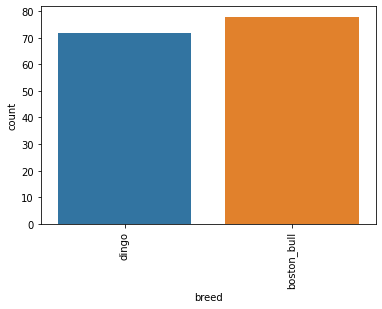

In [68]:
# Count the number of images that each breed has in train dataset and visualizing the same
import seaborn as sns
sns.countplot(train_df['breed'])
plt.xticks(rotation=90)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


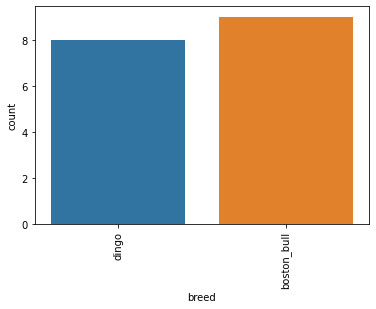

In [69]:
# Count the number of images that each breed has in test dataset and visualizing the same
import seaborn as sns
sns.countplot(test_df['breed'])
plt.xticks(rotation=90)
plt.show()

In [70]:
# Printing the average, max and min number of images per class for balanced distribution
print("average number of images per class: {}".format(train_df['breed'].value_counts().mean()))
print("max number of images per class: {}".format(train_df['breed'].value_counts().max()))
print("min number of images per class: {}".format(train_df['breed'].value_counts().min()))

average number of images per class: 75.0
max number of images per class: 78
min number of images per class: 72


**Regarding the distribution of the classes:** For this dataset the class distribution between different breeds is observed. And the class distribution is almost balanced between 126 and 66 images for different breeds. The average number of images per class is 85.18 and hence we can conclude that we can continue with the same dataset without changing since the distribution is almost same but not completely.


**** 2.3 Understanding the structure of the image****

**How a digital image is stored:** The three channels or matrices that is red matrix, green matrix and blue matrix are stacked, resulting in the shape of the image that will be displayed when the image is fed into a computer:
Number of pixels across the height * Number of pixels across width * Number of channels (3 - RGB)


In [71]:
# Reading a sample image in train folder
sample_image = cv2.imread((train_dir+'/'+train_df['id']+'.jpg')[0])

# Trying to understand the shape of the image
print("shape of the image:", sample_image.shape)

shape of the image: (500, 375, 3)


 **Explanation of Shape of Image:** We have seen that how image is stored and from that we say that 389 is the number of pixels of the image across the height, 500 is the number of pixels of the image across the width, and 3 is the number of channels that is RGB (since all the colors come from these colors).

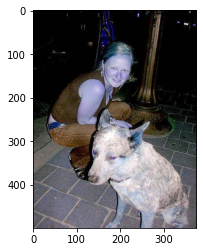

In [72]:
# Displaying the read image
plt.imshow(sample_image)

In [73]:
# Checking if all the images has same dimensions or not
for i in range(len(test_df)):
    print(cv2.imread(train_df.loc[i, "file_path"]).shape)

(500, 375, 3)
(292, 502, 3)
(375, 500, 3)
(375, 500, 3)
(282, 415, 3)
(375, 500, 3)
(375, 500, 3)
(500, 322, 3)
(375, 500, 3)
(375, 500, 3)
(500, 375, 3)
(500, 333, 3)
(332, 250, 3)
(375, 500, 3)
(332, 500, 3)
(333, 500, 3)
(500, 357, 3)


**NOTE:** We do see some images do have different dimensions. But only some of the images have different so hence continuing without resizing the images.

In [74]:
# Checking if all images have RGB i.e 3 channels
for i in range(len(train_df)):
    assert 3 == cv2.imread(train_df.loc[1,"file_path"]).shape[2], "image id {} does not have RGB"

If all the channels does not have the 3 channels of RGB then by executing this block it will throw the error. Oherwise it will execute successfully.

**NOTE:** Importance of having same dimensions for each image to pass it through any algorithm: This step playes a cruical part in this image classification since resizing of images is a critical preprocessing step in computer vision which takes lot of time. Even if there dimensions are not same they are downscaled to match dimensions from the smallest image available. There may be a reason for deleting some photographs from our dataset if a small number (let's say, fewer than 5%) of the total images are noticeably deformed in comparison to the others and those images do not disproportionately represent a single class or other attribute.

**3. Data Preprocessing**: These are the steps performed for preprocessing the data and getting it ready for feature extraction.

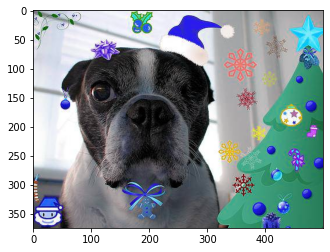

In [75]:
# Testing file_path has correctly populated or not.
plt.imshow(cv2.imread(train_df['file_path'][100]))

**3.2 Mapping dog breeds to numerical categories**

**Need to map classes in multi class classification into numbers:** The process of classifying items into various classes is known as multi-class classification. It doesn't limit itself to any particular number of classes, unlike binary.It is needed since here each breed should be taken as a separate class and then if we apply classification algorithm the accuracy will be more since it will be able to separate or differentiate between classes.

In [76]:
# Getting a list of all unique breeds and assigning the classes to breed
dog_breeds=sorted(list(set(train_df['breed'])))

# Number of classes
n_classes=len(dog_breeds)

# Creating a dict to map breed names to numbers.
classes_to_num=dict(zip(dog_breeds,range(n_classes)))

classes_to_num

{'boston_bull': 0, 'dingo': 1}

**3.3 Creating a numerical category for dog breeds**

Images should be converted so that it should be understandable by machines. Only the numbers the machines can understand so training and test data frame images are converted to numerical category. And here only binary class method is utilized. Where boston_bull is mapped as 0 class and Dingo is mapped to 1.

In [77]:
train_df['breed_number'] = train_df['breed'].map(classes_to_num)
test_df['breed_number'] = test_df['breed'].map(classes_to_num)
train_df

,id,breed,img_exist,file_name,file_path,breed_number
0,aadf0358c789a5b5aa558c66f580e92d,dingo,True,aadf0358c789a5b5aa558c66f580e92d.jpg,../input/dog-breed-identification/train/aadf03...,1
1,85af448e04bc04d107502330ff98ca65,dingo,True,85af448e04bc04d107502330ff98ca65.jpg,../input/dog-breed-identification/train/85af44...,1
2,387ae89153da8b0171322ab0cd54923e,boston_bull,True,387ae89153da8b0171322ab0cd54923e.jpg,../input/dog-breed-identification/train/387ae8...,0
3,f6bdbf94ffea753f4f7638784faf01cc,dingo,True,f6bdbf94ffea753f4f7638784faf01cc.jpg,../input/dog-breed-identification/train/f6bdbf...,1
4,4c7b7de42668d9a5b1dd5ee1f5190c22,dingo,True,4c7b7de42668d9a5b1dd5ee1f5190c22.jpg,../input/dog-breed-identification/train/4c7b7d...,1
...,...,...,...,...,...,...
145,1195f58740671fa1d73c91f39031e417,dingo,True,1195f58740671fa1d73c91f39031e417.jpg,../input/dog-breed-identification/train/1195f5...,1
146,6da0f1e6b600e038d4a8b53d96b0051f,dingo,True,6da0f1e6b600e038d4a8b53d96b0051f.jpg,../input/dog-breed-identification/train/6da0f1...,1
147,d6857f130c251f01ab973358cbfccce1,boston_bull,True,d6857f130c251f01ab973358cbfccce1.jpg,../input/dog-breed-identification/train/d6857f...,0
148,c3e1b303c9f7cfc15f57038400548af8,dingo,True,c3e1b303c9f7cfc15f57038400548af8.jpg,../input/dog-breed-identification/train/c3e1b3...,1


****3.4 Creating a constant shaped input and rescaling the pixel values from 1 - 255 to 0 - 1** **: The image is rescalled and resized in this step. Smaller images will process fast and the accuracy will be more. We know that image will be stored in the machine by interfering layers of RGB. In which each has matrix of 0 to 255 size. Therefore for this image we are recycling the image from 0 - 255 to 0 - 1 and the image properties will remain as it is. We can use the Keras preprocessing layers to resize your images to a consistent shape and to rescale pixel values.

In [78]:
# Taking the sample image
sample_image = cv2.imread(train_df['file_path'][100])

In [79]:
# Resizing and Rescaling the Image
IMG_SIZE = 331

resize_and_rescale = tf.keras.Sequential([
layers.Resizing(IMG_SIZE, IMG_SIZE),
layers.Rescaling(1./255)
])

In [80]:
# Checking the image after recycled 
new_resized_sample = resize_and_rescale(sample_image)

In [81]:
# It is resized to 331 Number of pixels across height, 331 number of pixels across weight and 3 channels
new_resized_sample.shape

TensorShape([331, 331, 3])

In [82]:
# checking if rescalling values are present between o to 1
print("Min and Max pixel values:", new_resized_sample.numpy().min(), new_resized_sample.numpy().max())


Min and Max pixel values: 0.0 1.0


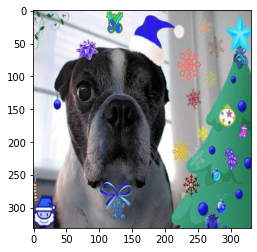

In [83]:
# Resized and scaled image
plt.imshow(new_resized_sample)

We can observe that after recycling and resizing the image looks the same but the dimensions are reduced now.

****3.5 Data Augmentation: **** It is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation. Using the keras we can achieve this step. It consists of preprocessing layers of resizing, rescaling and it also consists of methods such as image, brightness, central crop and many more. This step is performed because we are making the model confused here since it has to predict the breed correctly even if the image of dog will be in reverse direction. So we will be training our model in all the rotations by using keras random rotation and random flip.



In [84]:
# Performing the random flip and random rotation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

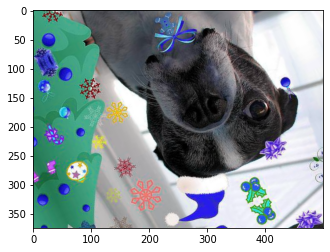

In [85]:
# View the transformed image
transformed_image = data_augmentation(sample_image)
plt.imshow(transformed_image)

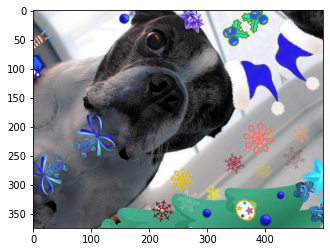

In [86]:
transformed_image_1 = data_augmentation(sample_image)
plt.imshow(transformed_image_1)

**4. Data Preparation for the Model Creation:**


In [87]:
# Defining a method to create dataset that comprise of image size so that machine can understand
img_size = 331
def get_data(df):
    data = []
    for i in range(len(df)):
        try:
            img_arr = cv2.imread(df.loc[i, "file_path"])
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, df.loc[i, "breed_number"]])
        except Exception as e:
            print(e)
    return np.array(data)

In [88]:
# Creating train and validation data
train = get_data(train_df)
test = get_data(test_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == "":


Here x is the input and y is the output. And x_train and y_train are utilized to train the model. x_val is the input that is used as validation of model which results are compared with y_val. And the data is normalized here so that image will be contrasted. It is a process that changes the range of pixel intensity values by dividing each of its pixel by the maximum pixel(255). It makes the image look better for visualization and will be computation efficient by reducing the values between 0 and 1. 

In [89]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [90]:
# Printing the shape of train input, train output, validation input and validation output
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(150, 331, 331, 3)
(150,)
(17, 331, 331, 3)
(17,)


In [91]:
# Generate the Data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

****5. Classification using BASIC CNN MODEL****: CNNs are a subset of Deep Neural Networks that are frequently employed for the analysis of visual pictures because of their ability to identify and categorize specific features from images. 
For feature extraction of image, the features of the images are extracted. The mathematical operation of convolution is performed and the dot product between the filter and the parts of the image is performed to extract the features of images in the convolution layer. 
The pooling layer summarizes the features that are generated by a convolution layer. Flatten is the function that converts the pooled feature map to a single ong continuous linear vector that is passed to the fully connected layer. Dense adds the fully connected layer to the neural network.

In [92]:
model_1 = Sequential()
model_1.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(331,331,3)))
model_1.add(MaxPool2D())
model_1.add(Flatten())
model_1.add(Dense(128,activation="relu"))
model_1.add(Dense(2, activation="softmax"))

model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 331, 331, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 165, 165, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 871200)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               111513728 
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 111,514,882
Trainable params: 111,514,882
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Compiling the model
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

Epochs is generally one pass over the dataset. Here we have given 100 passes so that it will check for 100 iterations on the train data and validate the data. The accuracy after each pass will be changed and become constant after some iteration. It gives the periodic evaluation on the dataset.

In [94]:
# Fitting the model and runnning it for 100 iterations
history_1 = model_1.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


5/5 [==============================] - 1s 99ms/step - loss: 178.4087 - accuracy: 0.4533 - val_loss: 77.1796 - val_accuracy: 0.5294
Epoch 2/100
5/5 [==============================] - 0s 63ms/step - loss: 23.1999 - accuracy: 0.5800 - val_loss: 7.6751 - val_accuracy: 0.5294
Epoch 3/100
5/5 [==============================] - 0s 65ms/step - loss: 15.1881 - accuracy: 0.5333 - val_loss: 17.9945 - val_accuracy: 0.5294
Epoch 4/100
5/5 [==============================] - 0s 63ms/step - loss: 11.8287 - accuracy: 0.5200 - val_loss: 11.5796 - val_accuracy: 0.4706
Epoch 5/100
5/5 [==============================] - 0s 62ms/step - loss: 5.5192 - accuracy: 0.6400 - val_loss: 23.7924 - val_accuracy: 0.5294
Epoch 6/100
5/5 [==============================] - 0s 62ms/step - loss: 8.3871 - accuracy: 0.5733 - val_loss: 2.3477 - val_accuracy: 0.6471
Epoch 7/100
5/5 [==============================] - 0s 64ms/step - loss: 4.9009 - accuracy: 0.6067 - val_loss: 4.2487 - val_accuracy: 0.5882
Epoch 8/100
5/5 [======

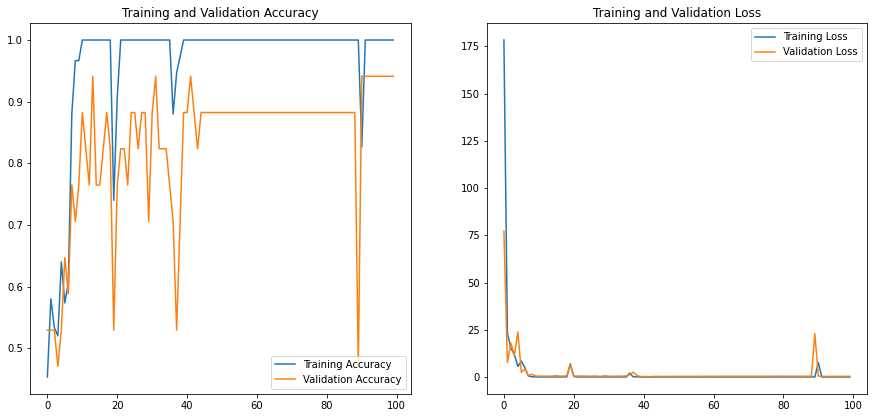

In [95]:
# Data Visualization: Plotting of accuracy and loss
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
# Predictions of precision, recall, f1-score, and support
predictions_1 = model_1.predict(x_val)
predictions_1 = np.argmax(predictions_1, axis=1)
print(classification_report(y_val, predictions_1, labels=[0,1], target_names = ['boston_bull: 0, dingo: 1']))

                          precision    recall  f1-score   support

boston_bull: 0, dingo: 1       1.00      0.89      0.94         9

                accuracy                           0.94        17
               macro avg       0.94      0.94      0.94        17
            weighted avg       0.95      0.94      0.94        17



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2128: UserWarning: labels size, 2, does not match size of target_names, 1
  len(labels), len(target_names)


In [97]:
# Printing the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predictions_1)

0.9411764705882353

****6. Classification using CNN MODEL with more hidden layers:** **Extra layers were added to check the accuracy that if we receive greater accuracy than the previous method or not. 

In [98]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(331,331,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 331, 331, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 165, 165, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 165, 165, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 82, 82, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 41, 64)       

In [99]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

Epochs is generally one pass over the dataset. Here we have given 100 passes so that it will check for 100 iterations on the train data and validate the data. The accuracy after each pass will be changed and become constant after some iteration. It gives the periodic evaluation on the dataset.

In [100]:
history = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


5/5 [==============================] - 1s 91ms/step - loss: 6.0732 - accuracy: 0.5733 - val_loss: 0.9712 - val_accuracy: 0.4706
Epoch 2/100
5/5 [==============================] - 0s 54ms/step - loss: 0.7691 - accuracy: 0.4667 - val_loss: 0.6638 - val_accuracy: 0.7059
Epoch 3/100
5/5 [==============================] - 0s 56ms/step - loss: 0.7073 - accuracy: 0.4933 - val_loss: 0.6499 - val_accuracy: 0.5882
Epoch 4/100
5/5 [==============================] - 0s 55ms/step - loss: 0.6661 - accuracy: 0.6867 - val_loss: 0.6488 - val_accuracy: 0.4706
Epoch 5/100
5/5 [==============================] - 0s 56ms/step - loss: 0.6296 - accuracy: 0.6000 - val_loss: 0.5762 - val_accuracy: 0.7059
Epoch 6/100
5/5 [==============================] - 0s 55ms/step - loss: 0.5405 - accuracy: 0.7400 - val_loss: 0.6112 - val_accuracy: 0.7059
Epoch 7/100
5/5 [==============================] - 0s 65ms/step - loss: 0.5305 - accuracy: 0.7400 - val_loss: 0.6947 - val_accuracy: 0.5294
Epoch 8/100
5/5 [===============

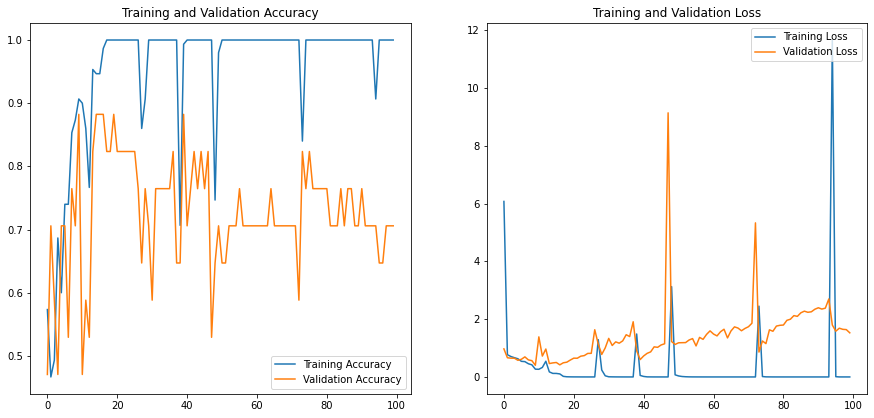

In [101]:
# Data Visualization: Plotting of accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above graph we can observe that loss became less and constant after 20th iteration and accuracy is also almost constant and high after 30th iteration. Together we can say that for this dataset epochs can be in between 20 to 30 instead of 100.

In [102]:
# Predictions of precision, recall, f1-score, and support
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
print(classification_report(y_val, predictions, labels=[0,1], target_names = ['boston_bull: 0, dingo: 1']))

                          precision    recall  f1-score   support

boston_bull: 0, dingo: 1       0.83      0.56      0.67         9

                accuracy                           0.71        17
               macro avg       0.73      0.72      0.70        17
            weighted avg       0.74      0.71      0.70        17



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2128: UserWarning: labels size, 2, does not match size of target_names, 1
  len(labels), len(target_names)


In [103]:
# Printing the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predictions)

0.7058823529411765